Convex Hull Area: 393.00
Team Dispersion: X: 27.97, Y: 29.74
Average Distance Between Lines: 32.22
Top Passer (Centrality): C. Eiting
Team Clustering Coefficient: 0.00
Passing Entropy: 3.15
Average Speed of Players:
playerName
B. Brobbey            NaN
B. Plat               NaN
C. Bassey             NaN
C. Eiting             NaN
C. Twigt              NaN
D. James              NaN
D. Klaassen           NaN
D. Mirani             NaN
D. Murkin             NaN
D. Rensch             NaN
D. Tadić              NaN
D. van Mieghem        NaN
E. Álvarez            NaN
F. Da Silva           NaN
F. Stanković          NaN
Francisco Conceição   NaN
G. Oristanio          NaN
G. Rulli              NaN
H. Veerman            NaN
J. Flint              NaN
J. Timber             NaN
K. Taylor             NaN
L. Lucca              NaN
M. Kudus              NaN
O. Buur               NaN
S. Berghuis           NaN
S. Bergwijn           NaN
W. Ould-Chikh         NaN
X. Mbuyamba           NaN
Name: speed, dtype:

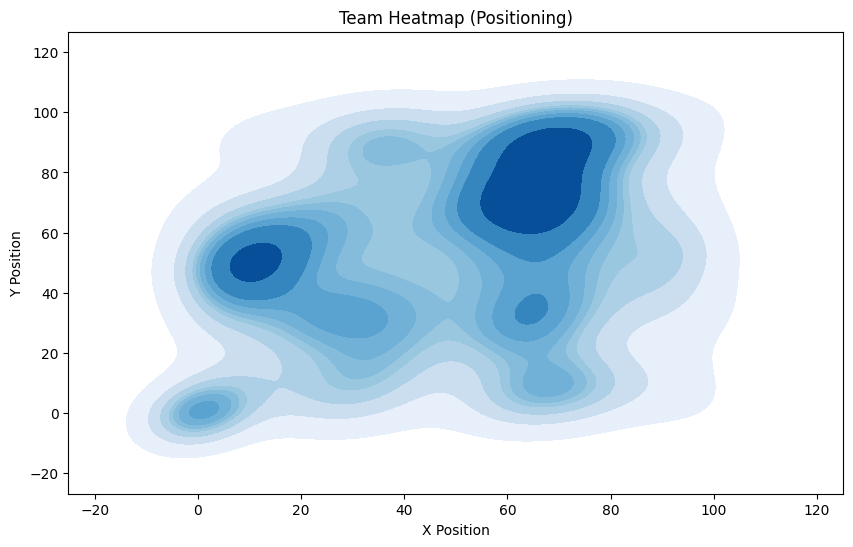


📊 **Final Insights**:
🟡 The team exhibits a **Hybrid Playstyle**.


In [10]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull
from scipy.stats import entropy

# -------------------------------
# 🔹 1. Load Data
# -------------------------------
file_path = "/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2022-2023/Ajax 1-1 Volendam.csv"  # Update this with your actual file
df = pd.read_csv(file_path)


# Selecting relevant columns
df = df[['id', 'eventId', 'typeId', 'periodId', 'timeMin', 'timeSec', 'contestantId', 'outcome', 
         'x', 'y', 'playerId', 'playerName', 'keyPass', 'assist']]

# Convert timestamps to match time in seconds
df['timeInSeconds'] = df['timeMin'] * 60 + df['timeSec']

# -------------------------------
# 🔹 2. Convex Hull (Team Shape)
# -------------------------------
def calculate_convex_hull_area(positions):
    """Calculate the convex hull area of team positions"""
    if len(positions) < 3:
        return 0  # Convex hull needs at least 3 points
    hull = ConvexHull(positions)
    return hull.area

team_positions = df[['x', 'y']].dropna().to_numpy()
convex_hull_area = calculate_convex_hull_area(team_positions)
print(f"Convex Hull Area: {convex_hull_area:.2f}")

# -------------------------------
# 🔹 3. Player Dispersion (Compactness)
# -------------------------------
def calculate_team_dispersion(positions):
    """Calculate standard deviation of player positions to measure dispersion"""
    return np.std(positions, axis=0)

dispersion = calculate_team_dispersion(team_positions)
print(f"Team Dispersion: X: {dispersion[0]:.2f}, Y: {dispersion[1]:.2f}")

# -------------------------------
# 🔹 4. Distance Between Lines (Fixed)
# -------------------------------

# Compute average positions per player
player_positions = df.groupby('playerName')[['x', 'y']].mean().reset_index()

# Sort players by Y position (Assumption: Lower Y = Deeper player)
player_positions = player_positions.sort_values(by='y')

# Assign roles dynamically based on team size
num_defenders = 4  # Adjust if you have actual player roles
num_midfielders = 3
num_forwards = len(player_positions) - num_defenders - num_midfielders

defenders = player_positions.iloc[:num_defenders][['x', 'y']].values
midfielders = player_positions.iloc[num_defenders:num_defenders+num_midfielders][['x', 'y']].values
forwards = player_positions.iloc[num_defenders+num_midfielders:][['x', 'y']].values

def average_distance_between_lines(defenders, midfielders, forwards):
    """Calculate spacing between lines of play"""
    d_m = np.mean([np.linalg.norm(m - d) for d in defenders for m in midfielders])
    m_f = np.mean([np.linalg.norm(f - m) for m in midfielders for f in forwards])
    return (d_m + m_f) / 2

avg_distance = average_distance_between_lines(defenders, midfielders, forwards)
print(f"Average Distance Between Lines: {avg_distance:.2f}")

# -------------------------------
# 🔹 5. Passing Network Analysis
# -------------------------------
pass_data = df[df['typeId'] == 1]  # Assuming passes are event typeId = 1
pass_graph = nx.DiGraph()

for _, row in pass_data.iterrows():
    passer = row['playerName']
    receiver = row['outcome']  # Outcome might store receivers (check your dataset)
    if pd.notna(receiver):
        pass_graph.add_edge(passer, receiver)

# **Betweenness Centrality (Playmaker Influence)**
centrality = nx.betweenness_centrality(pass_graph)
print(f"Top Passer (Centrality): {max(centrality, key=centrality.get, default='No Passes')}")

# **Clustering Coefficient (Team Connectivity)**
if len(pass_graph.nodes) > 0:
    clustering_coeff = nx.average_clustering(nx.Graph(pass_graph))
else:
    clustering_coeff = 0
print(f"Team Clustering Coefficient: {clustering_coeff:.2f}")

# **Entropy of Passing (Unpredictability)**
pass_counts = df['playerName'].value_counts().values
passing_entropy = entropy(pass_counts) if len(pass_counts) > 0 else 0
print(f"Passing Entropy: {passing_entropy:.2f}")

# -------------------------------
# 🔹 6. Movement & Synchronization
# -------------------------------
df['dx'] = df['x'].diff()
df['dy'] = df['y'].diff()
df['speed'] = np.sqrt(df['dx']**2 + df['dy']**2) / df['timeInSeconds'].diff()

# Average speed of players
average_speed = df.groupby('playerName')['speed'].mean()
print(f"Average Speed of Players:\n{average_speed}")

# -------------------------------
# 🔹 7. Verticality & Directness
# -------------------------------
def calculate_directness_ratio(df):
    """Measures vertical vs. lateral passing ratio"""
    vertical_passes = df[(df['dx'].abs() > df['dy'].abs())]  # More vertical movement
    lateral_passes = df[(df['dx'].abs() < df['dy'].abs())]  # More lateral movement
    return len(vertical_passes) / max(len(lateral_passes), 1)

directness_ratio = calculate_directness_ratio(df)
print(f"Directness Index (Higher = More Direct Play): {directness_ratio:.2f}")

# -------------------------------
# 🔹 8. Key Passes & Assists
# -------------------------------
key_passes = df[df['keyPass'] == 1]
assists = df[df['assist'] == 1]

print(f"Total Key Passes: {len(key_passes)}")
print(f"Total Assists: {len(assists)}")

# -------------------------------
# 🔹 9. Visualizations (Fixed)
# -------------------------------
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df['x'], y=df['y'], cmap="Blues", fill=True)
plt.title("Team Heatmap (Positioning)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()

# -------------------------------
# 🔹 10. Interpretation
# -------------------------------
print("\n📊 **Final Insights**:")
if convex_hull_area < 3000 and clustering_coeff > 0.5:
    print("🔵 This team follows a **Positional Play** style (structured, low variability).")
elif passing_entropy > 2.0 and directness_ratio > 1.5:
    print("🔴 This team follows a **Relationist Play** style (fluid, high unpredictability).")
else:
    print("🟡 The team exhibits a **Hybrid Playstyle**.")
